# Low Resource Language ASR model
### Lars Ericson, Catskills Research Company, OpenASR20

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

## Language Analysis

In [3]:
from Language import Language
L=Language('amharic')

/home/catskills/anaconda3/envs/openasr/lib/python3.8/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


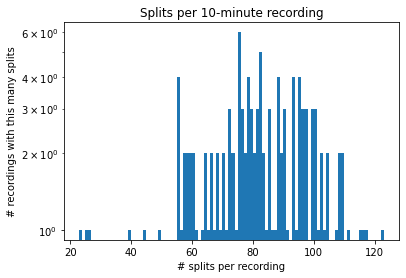

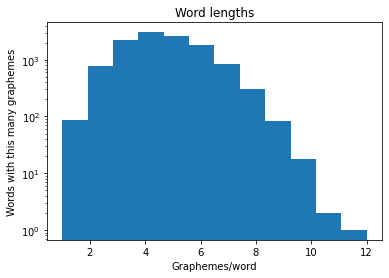

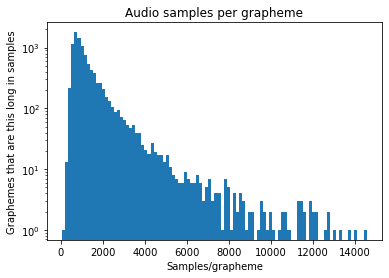

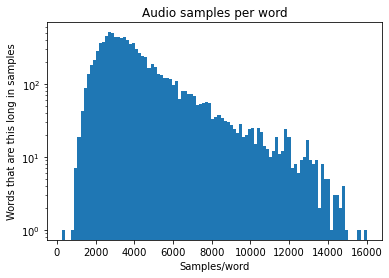

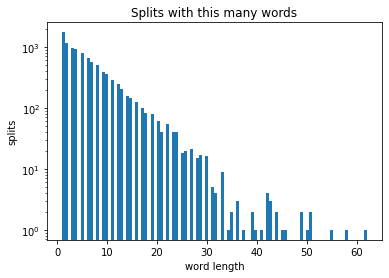

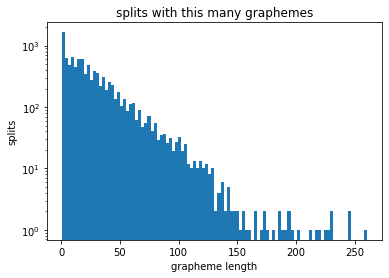

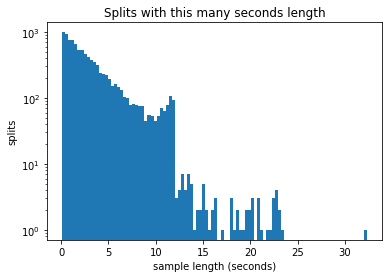

In [4]:
L.visualization()

In [133]:
dfL=L.sample_statistics()
dfL

,Corpus,Units,Measurement,Value
0,Recordings,#Hours,Hours of training speech,20.333333
1,Recordings,#Recordings,10-minute training recordings,122.000000
0,Graphemes,#Graphemes,Distinct graphemes in all transcriptions,234.000000
1,Graphemes,Length in samples,Max,14560.000000
2,Graphemes,Length in samples,Mean,1350.801423
3,Graphemes,Length in samples,Median,971.637255
4,Graphemes,Length in samples,Min,67.692308
5,Graphemes,Length in seconds,Max,1.820000
6,Graphemes,Length in seconds,Mean,0.168850
7,Graphemes,Length in seconds,Median,0.121455


## Sub splitting based on words per split and average samples per grapheme (imperfect, introduces error)

### Trim all samples aggressively and examine the longest trimmed 1-word sample and resulting distribution

In [6]:
fat=L.splits
skinny=fat.aggressive_clip_ends()
one_word_fat=[x for x in fat.artifacts if x.target.n_words==1]
one_word_skinny=[x for x in skinny.artifacts if x.target.n_words==1]
both=list(zip(one_word_fat, one_word_skinny))
one_word=sorted(both, key = lambda x: x[0].source.n_samples)
len(one_word)

In [19]:
(old,new)=one_word[-1]

SOURCE


TARGET
ይሰማሀል :: yesamaahale


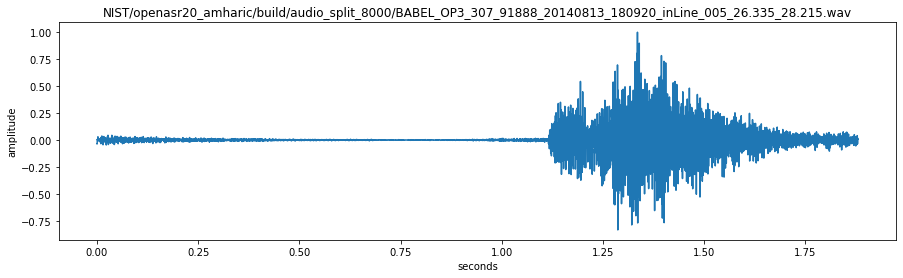

In [20]:
old.display()

SOURCE


TARGET
ይሰማሀል :: yesamaahale


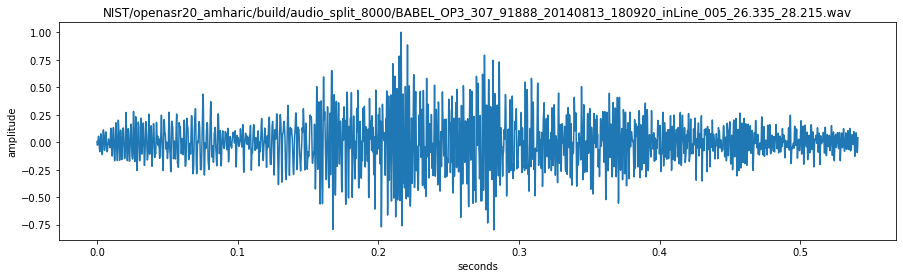

In [21]:
new.display()

In [50]:
fat.diff_sample_statistics(skinny)

,Corpus,Units,Measurement,Value_x,Value_y
2,Graphemes,Length in samples,Mean,1350.801423,1278.735745
3,Graphemes,Length in samples,Median,971.637255,932.976804
6,Graphemes,Length in seconds,Mean,0.168850,0.159842
7,Graphemes,Length in seconds,Median,0.121455,0.116622
9,Split Speech,Length in samples,Max,258311.000000,251309.000000
10,Split Speech,Length in samples,Mean,26010.961187,24958.481203
11,Split Speech,Length in samples,Median,17944.500000,17008.000000
12,Split Speech,Length in samples,Min,897.000000,522.000000
13,Split Speech,Length in seconds,Max,32.288875,31.413625
14,Split Speech,Length in seconds,Mean,3.251370,3.119810


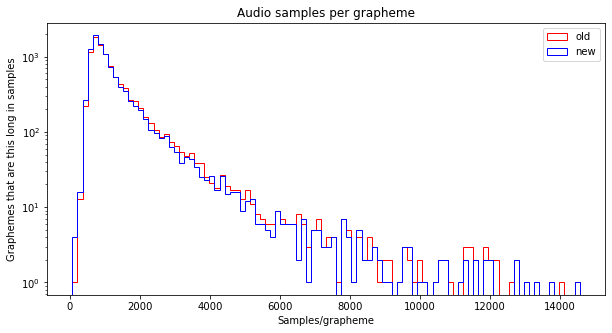

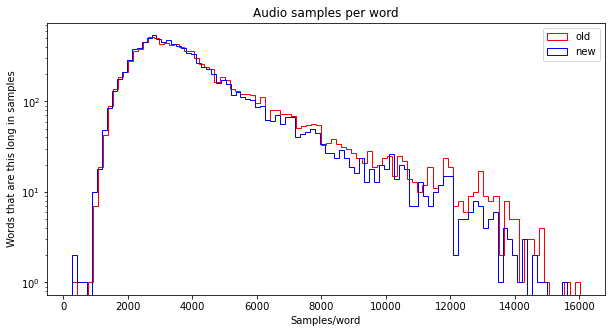

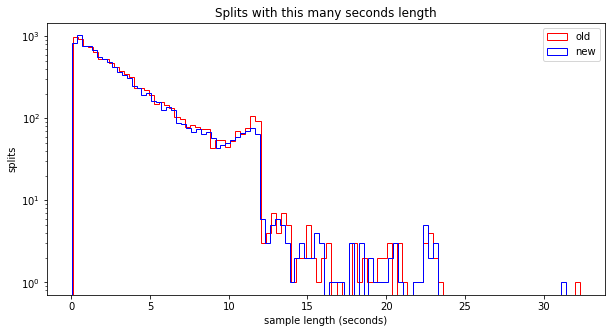

In [74]:
fat.diff_visualization(skinny)

### Split the longest sample by silence gaps, aggressively trim each, then allocate graphemes evenly over the clips, maximizing alignment of graphemes to word boundaries on silence

In [33]:
df=skinny.sample_statistics()
max_words=int(df[(df.Corpus=="Split Transcription") & (df.Units=="Length in words") & (df.Measurement=="Max")].Value.values[0])
max_words

62

In [135]:
target_max_sample_length=int(df[(df.Corpus=="Split Speech") & (df.Units=="Length in samples") & (df.Measurement=="Median")].Value.values[0])
target_max_sample_length

17008

In [134]:
df

,Corpus,Units,Measurement,Value
0,Graphemes,#Graphemes,Distinct graphemes in all transcriptions,234.000000
1,Graphemes,Length in samples,Max,14560.000000
2,Graphemes,Length in samples,Mean,1278.735745
3,Graphemes,Length in samples,Median,932.976804
4,Graphemes,Length in samples,Min,67.692308
5,Graphemes,Length in seconds,Max,1.820000
6,Graphemes,Length in seconds,Mean,0.159842
7,Graphemes,Length in seconds,Median,0.116622
8,Graphemes,Length in seconds,Min,0.008462
9,Split Speech,Length in samples,Max,251309.000000


In [34]:
max_words_skinny=[x for x in skinny.artifacts if x.target.n_words==max_words]
len(max_words_skinny)

1

In [35]:
artifact=max_words_skinny[0]

SOURCE


TARGET
ፋሚሊዎቼ እንደዚህ ከቤት ውጭ ምናምን ማደር የሚባል ነገር አይወዱም ከ  ከዘር ነው መሰለኝ ማለት ሁሉም አይወዱም እና ለምንድን ነው ከቤት ውጭ የምታድረው የትም መዋል ግን ትናንትና እራሱ ማለት ነው ከትላንት ወዲያ ሌላ ቦታ አድሬ መጥቼ ማለት ነው የ  የሆነ ጀለሴ ጋር ነበርኩ እና ማለት መጥፎ ቦታ የምታሳልፍ ነው የሚመስላቸው የሆነ አጉል ቦታ ምናምን ሄደህ የምትመጣ እና እንደ ህፃን ልጅ ነው የሚያዩኝ እኔን :: faamiliwocee 'enedazihe kabeete weche menaamene maadare yamibaale nagare 'ayewadume ka  kazare nawe masalanye maalate hulume 'ayewadume 'enaa lamenedene nawe kabeete weche yametaaderawe yateme mawaale gene tenaanetenaa 'eraasu maalate nawe katelaanete wadiyaa leelaa botaa 'aderee mathecee maalate nawe ya  yahona jalasee gaare nabareku 'enaa maalate mathefo botaa yametaasaalefe nawe yamimaselaacawe yahona 'agule botaa menaamene heedahe yametemathaa 'enaa 'eneda hetzaane leje nawe yamiyaayunye 'eneene


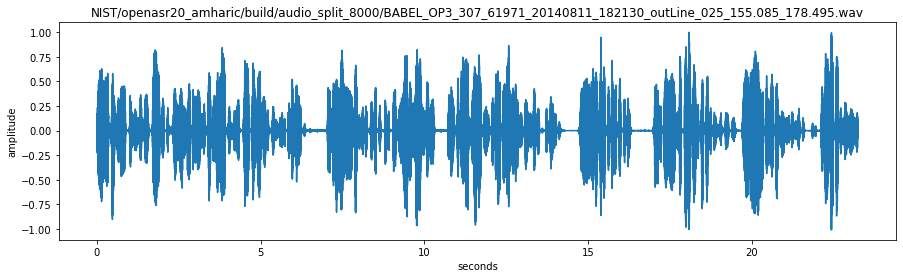

In [36]:
artifact.display()

In [197]:
from split_to_target_sample_length import split_to_target_sample_length

In [204]:
A=split_to_target_sample_length(artifact, target_max_sample_length, 'graphemes')

In [205]:
len(A)

11

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LLLL
SOURCE


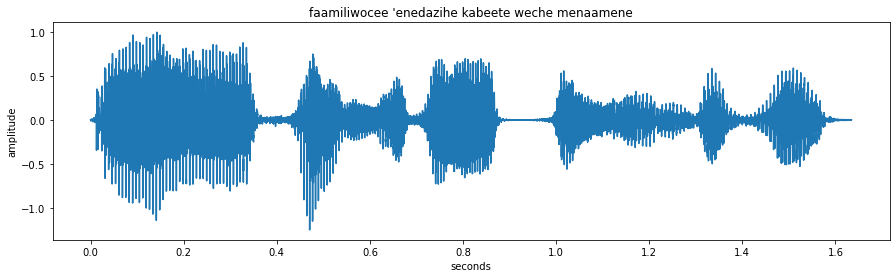

TARGET
ፋሚሊዎቼ እንደዚህ ከቤት ውጭ ምናምን :: faamiliwocee 'enedazihe kabeete weche menaamene

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LLLR
SOURCE


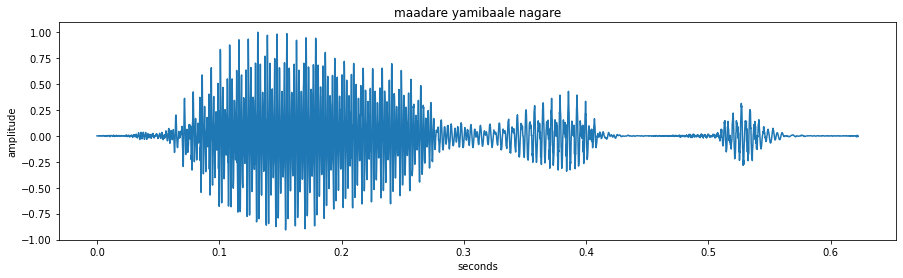

TARGET
ማደር የሚባል ነገር :: maadare yamibaale nagare

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LLRLL
SOURCE


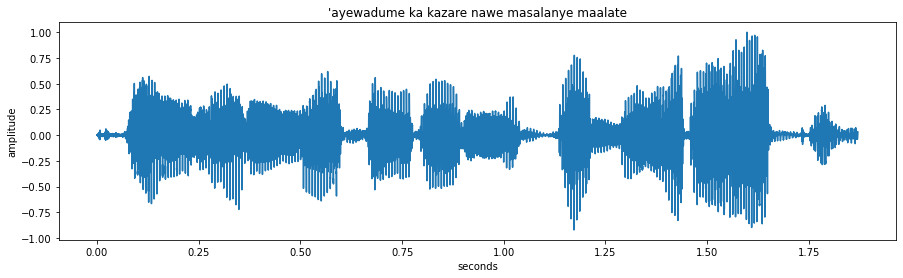

TARGET
አይወዱም ከ ከዘር ነው መሰለኝ ማለት :: 'ayewadume ka kazare nawe masalanye maalate

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LLRLR
SOURCE


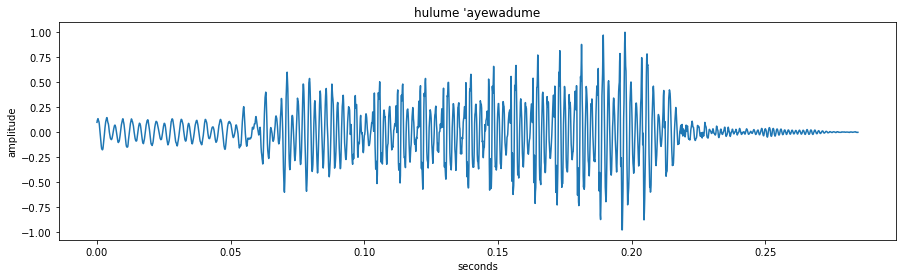

TARGET
ሁሉም አይወዱም :: hulume 'ayewadume

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LLRR
SOURCE


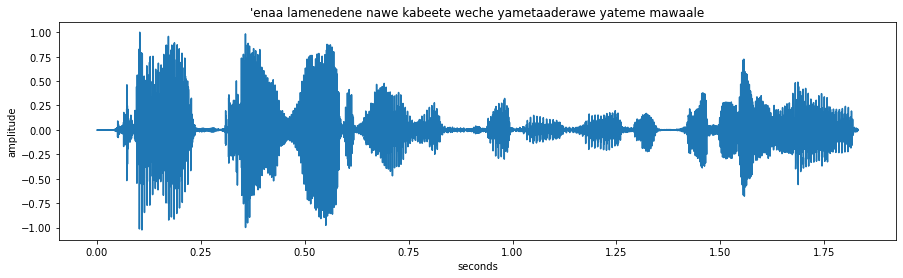

TARGET
እና ለምንድን ነው ከቤት ውጭ የምታድረው የትም መዋል :: 'enaa lamenedene nawe kabeete weche yametaaderawe yateme mawaale

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LRLLLL
SOURCE


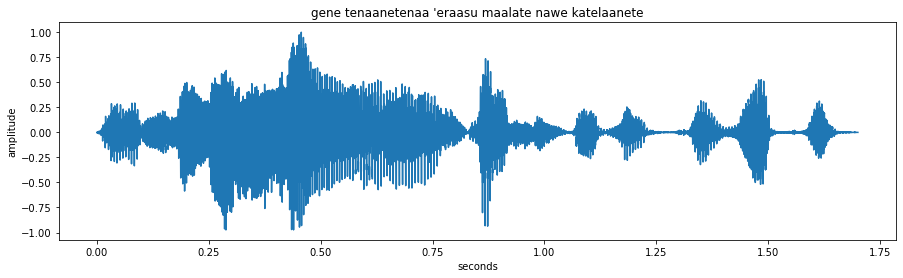

TARGET
ግን ትናንትና እራሱ ማለት ነው ከትላንት :: gene tenaanetenaa 'eraasu maalate nawe katelaanete

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LRLLLR
SOURCE


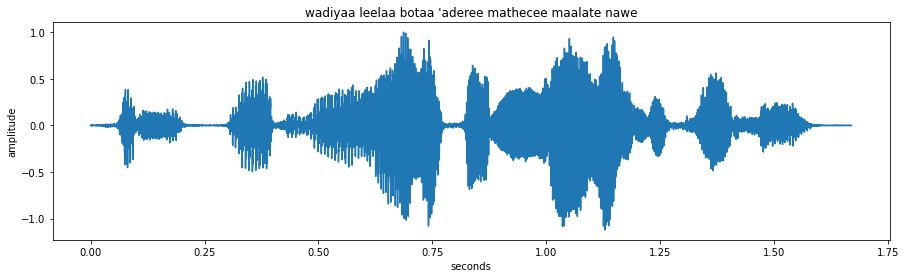

TARGET
ወዲያ ሌላ ቦታ አድሬ መጥቼ ማለት ነው :: wadiyaa leelaa botaa 'aderee mathecee maalate nawe

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LRLLR
SOURCE


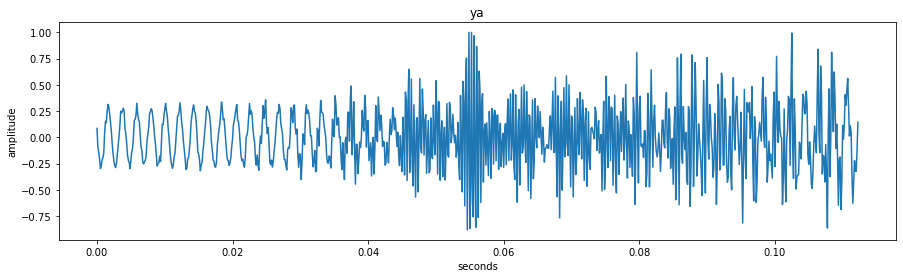

TARGET
የ :: ya

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LRLR
SOURCE


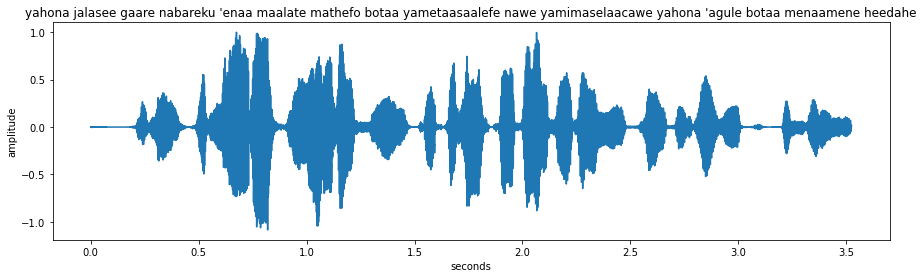

TARGET
የሆነ ጀለሴ ጋር ነበርኩ እና ማለት መጥፎ ቦታ የምታሳልፍ ነው የሚመስላቸው የሆነ አጉል ቦታ ምናምን ሄደህ :: yahona jalasee gaare nabareku 'enaa maalate mathefo botaa yametaasaalefe nawe yamimaselaacawe yahona 'agule botaa menaamene heedahe

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495LRR
SOURCE


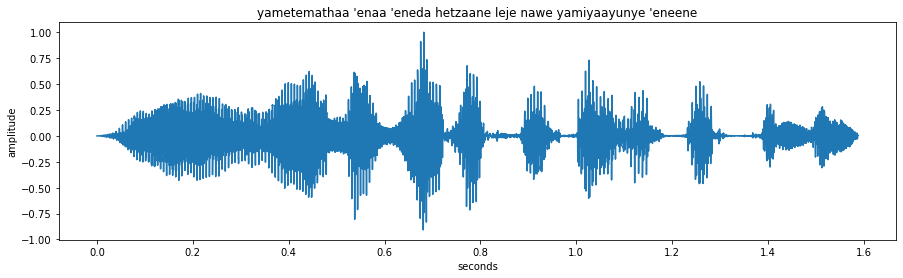

TARGET
የምትመጣ እና እንደ ህፃን ልጅ ነው የሚያዩኝ እኔን :: yametemathaa 'enaa 'eneda hetzaane leje nawe yamiyaayunye 'eneene

KEY BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495R
SOURCE


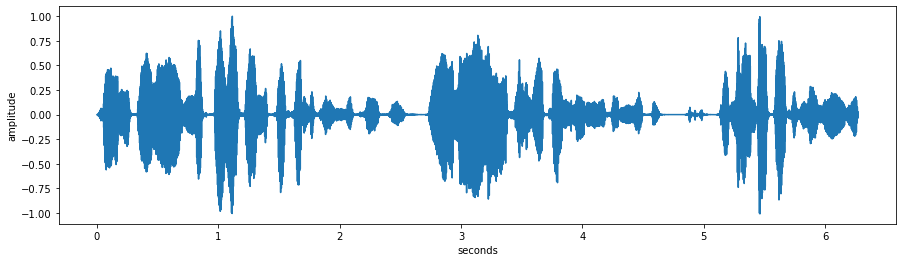

TARGET
 :: 



In [206]:
for arti in A:
    arti.display()

## Make a test training corpus

In [ ]:
clips=[]
for i, sound in enumerate(sounds):
    fn=f"frob/clip_{i}.wav"
    sf.write(fn, sound, C.sample_rate)
    clips.append(fn)

text='infer.txt'
manifest_fn='manifest.csv'
manifest='\n'.join([f'{audio},{text}' for audio in clips])
with open(manifest_fn, 'w') as f:        plt.show()
    f.write(manifest)

!cat manifest.csv

## ASR end-to-end speech-to-grapheme model stacked on top of grapheme-to-grapheme corrector model

In [ ]:
C.extension='_gradscaler'
C.batch_size=12
C.save_every = 5
C.start_from = 246

In [ ]:

import json, sys, os, librosa, random, math, time, torch
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')
os.environ['IN_JUPYTER']='True'
import numpy as np
import pandas as pd

from itertools import groupby
from operator import itemgetter
import soundfile as sf
from utils import constant
from utils.functions import load_model
from utils.data_loader import SpectrogramDataset, AudioDataLoader, BucketingSampler
from clip_ends import clip_ends
import torch.optim as optim
import torchtext
from torchtext.data import Field, BucketIterator
from torchtext.data import TabularDataset
import matplotlib.ticker as ticker
from IPython.display import Audio
from unidecode import unidecode
from seq_to_seq import *

In [ ]:
args=constant.args
args.continue_from=None
args.cuda = True
args.labels_path = C.grapheme_dictionary_fn
args.lr = 1e-4
args.name = C.model_name
args.save_folder = f'save'
args.epochs = 1000
args.save_every = 1
args.feat_extractor = f'vgg_cnn'
args.dropout = 0.1
args.num_layers = 4
args.num_heads = 8
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle=True
args.min_lr = 1e-6
args.k_lr = 1
args.sample_rate=C.sample_rate
args.continue_from=C.best_model
args.augment=True
audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

In [ ]:
with open(args.labels_path, 'r') as label_file:
    labels = str(''.join(json.load(label_file)))
# add PAD_CHAR, SOS_CHAR, EOS_CHAR
labels = constant.PAD_CHAR + constant.SOS_CHAR + constant.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0
for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])

model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(constant.args.continue_from)

In [ ]:
train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=[manifest_fn], 
                                label2id=label2id, normalize=True, augment=args.augment)
args.batch_size=1
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

strs_hyps=[]
for i, (data) in enumerate(tqdm(train_loader)):
    src, tgt, _, src_lengths, tgt_lengths = data
    src = src.cuda()
    tgt = tgt.cuda()
    pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)
    seq_length = pred.size(1)
    for ut_hyp in hyp_seq:
        str_hyp = ""
        for x in ut_hyp:
            if int(x) == constant.PAD_TOKEN:
                break
            str_hyp = str_hyp + id2label[int(x)]
        strs_hyps.append(str_hyp)
for j in range(len(strs_hyps)):
    strs_hyps[j] = strs_hyps[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')

In [ ]:
gold_tgt = ' '.join([x.strip() for x in gold_tgt.split(' ') if x])
gold_tgt

In [ ]:
pred=' '.join(strs_hyps)
pred

In [ ]:
error_correction_training_fn='frob/pred_gold.tsv'
with open(error_correction_training_fn, 'w', encoding='utf-8') as f:
    f.write(f"{gold_tgt}\t{pred}")

In [ ]:
!cat frob/pred_gold.tsv

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
from torchtext.data import Iterator

In [ ]:
train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [ ]:
train_iterator = Iterator(train_data, batch_size=1)

In [ ]:
gold_fns=list(sorted(glob(f'{C.build_dir}/transcription_split/*.txt')))
len(gold_fns)
import os
goldrows=[]
for fn in gold_fns:
    with open(fn, 'r', encoding='utf-8') as f:
        goldrows.append(f.read())

MAX_LENGTH=max(len(x) for x in goldrows)+10
MAX_LENGTH

graphemes=''.join([x for x in C.grapheme_dictionary])

MIN_FREQ=1

In [ ]:
SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

In [ ]:
TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

In [ ]:
dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [ ]:
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
model_fn='tut6-model.pt'

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
model.train()

In [ ]:
for j in range(100):
    epoch_loss = 0
    for i, batch in enumerate(train_iterator):

        src = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        epoch_loss += loss.item()
        
    print(j, epoch_loss)

In [ ]:
pred=output.argmax(1).cpu().detach().numpy()
pred

In [ ]:
''.join([SRC.vocab.itos[x] for x in src.cpu().numpy()[0]])

In [ ]:
silver=''.join([TRG.vocab.itos[x] for x in trg.cpu().numpy()]).split('<eos>')[0]
silver

In [ ]:
pred=''.join([TRG.vocab.itos[x] for x in pred]).split('<eos>')[0]
pred

In [ ]:
from utils.metrics import calculate_cer, calculate_wer

In [ ]:
calculate_cer(pred, silver)

In [ ]:
calculate_wer(pred, silver)